real_estate1083
real_estate1084
real_estate1033
real_estate1023
real_estate1073
real_estate1021
real_estate1094
real_estate1092
real_estate1022
real_estate1034
real_estate1101
real_estate1104
real_estate1061
real_estate1091
real_estate1111
real_estate1082
real_estate1031
real_estate1051
real_estate1042
real_estate1113
real_estate1053
real_estate1041
real_estate1063
real_estate1024
real_estate1032
real_estate1081
real_estate1093
real_estate1114
real_estate1044
real_estate1054
real_estate1103
real_estate1112
real_estate1064
real_estate1071
real_estate1072
real_estate1062
real_estate1102
real_estate1074
real_estate1052
real_estate1043


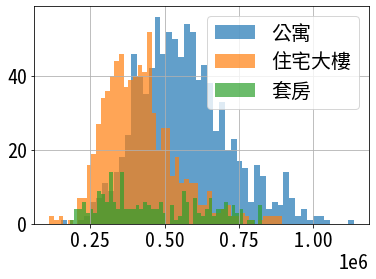

In [20]:
import requests
import os
import zipfile
import time
import pandas as pd

# 指定字體
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt


font_dirs = ["fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams["font.family"] = "Noto Sans Mono CJK TC"


def real_estate_crawler(year, season):
    if year > 1000:
        year -= 1911

    # download real estate zip file
    res = requests.get(
        "https://plvr.land.moi.gov.tw//DownloadSeason?season="
        + str(year)
        + "S"
        + str(season)
        + "&type=zip&fileName=lvr_landcsv.zip"
    )

    # save content to file
    fname = str(year) + str(season) + ".zip"
    open(fname, "wb").write(res.content)

    # make additional folder for files to extract
    folder = "real_estate" + str(year) + str(season)
    if not os.path.isdir(folder):
        os.mkdir(folder)

    # extract files to the folder
    with zipfile.ZipFile(fname, "r") as zip_ref:
        zip_ref.extractall(folder)

    time.sleep(10)


if __name__ == "__main__":
    # for year in range(102, 112):
    #    for season in range(1, 5):
    #        print(year, season)
    #        real_estate_crawler(year, season)

    # 歷年資料夾
    dirs = [d for d in os.listdir() if d[:4] == "real"]
    dirs.remove("real-estate-analasys-histograms.py")
    dirs.remove("real-estate-analasys-histograms.ipynb")

    dfs = []

    for d in dirs:
        print(d)
        df = pd.read_csv(os.path.join(d, "a_lvr_land_a.csv"), index_col=False)
        df["Q"] = d[-1]
        dfs.append(df.iloc[1:])

    df = pd.concat(dfs, sort=True)
    # print(df, df.columns)

    # 新增交易年份
    df["year"] = df["交易年月日"].str[:-4].astype(int) + 1911

    # 不同名稱同項目資料合併
    df["單價元平方公尺"].fillna(df["單價元平方公尺"], inplace=True)
    # df.drop(columns='單價元/平方公尺')

    # 平方公尺換成坪
    df["單價元平方公尺"] = df["單價元平方公尺"].astype(float)
    df["單價元坪"] = df["單價元平方公尺"] * 3.30579

    # 建物型態
    df["建物型態2"] = df["建物型態"].str.split("(").str[0]

    # 刪除有備註之交易（多為親友交易、價格不正常之交易）
    df = df[df["備註"].isnull()]

    # 將index改成年月日
    df.index = pd.to_datetime(
        (df["交易年月日"].str[:-4].astype(int) + 1911).astype(str) + df["交易年月日"].str[-4:],
        errors="coerce",
    )
    # print(df.columns)
    '''
    prices = {}
    for district in set(df["鄉鎮市區"]):
        cond = (
            (df["主要用途"] == "住家用")
            & (df["鄉鎮市區"] == district)
            & (df["單價元坪"] < df["單價元坪"].quantile(0.95))
            & (df["單價元坪"] > df["單價元坪"].quantile(0.05))
        )
        groups = df[cond]["year"]
        prices[district] = (
            df[cond]["單價元坪"].astype(float).groupby(groups).mean().loc[2012:]
        )

    price_history = pd.DataFrame(prices)
    price_history.plot(figsize=(20, 10)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
    )

    # 將所有地區的房價平均起來
    # price_history.mean(axis=1).plot()


    # 建物型態
    building_type_prices = {}
    for building_type in set(df["建物型態2"]):
        cond = (
            (df["主要用途"] == "住家用")
            & (df["單價元坪"] < df["單價元坪"].quantile(0.8))
            & (df["單價元坪"] > df["單價元坪"].quantile(0.2))
            & (df["建物型態2"] == building_type)
        )
        building_type_prices[building_type] = (
            df[cond]["單價元坪"].groupby(df[cond]["year"]).mean().loc[2012:]
        )
    pd.DataFrame(building_type_prices)[["公寓", "住宅大樓", "套房", "華廈"]].plot(figsize=(20, 10)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
    )

    

    # 分佈圖
    plt.rcParams["font.size"] = 20
    for district in set(df["鄉鎮市區"]):
        dfdistrict = df[df["鄉鎮市區"] == district]
        dfdistrict["單價元坪"][dfdistrict["單價元坪"] < 2000000].hist(bins=120, alpha=0.7)

    plt.xlim(0, 2000000)
    plt.legend(set(df["鄉鎮市區"]))
    '''

    # 建案型態製作分佈圖
    dfdistrict = df[
        (df["鄉鎮市區"] == "北投區")
        & (df["year"] >= 2018)
        & ((df["建物型態2"] == "住宅大樓") | (df["建物型態2"] == "公寓") | (df["建物型態2"] == "套房"))
    ]
    dfdistrict = dfdistrict[dfdistrict["單價元坪"] < 2000000]

    dfdistrict["單價元坪"].groupby(dfdistrict["建物型態2"]).hist(bins=50, alpha=0.7)
    plt.legend(set(dfdistrict["建物型態2"]))
